In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import json
import numpy as np
import os

In [2]:
scmap_str = json.loads(open("./DataPrep/scmap.json", "r").read())
scmap = {int(k): v for k, v in scmap_str.items()}
scmap[0xffff] = "NOSC"
scmap_r = {v: k for k, v in scmap.items()}

In [3]:
eval_fns = []
eval_dir = "eval_out"
for f in os.listdir(eval_dir):
    #if f.endswith(".eval_sample"):
    #    eval_fns.append(os.path.join(eval_dir, f))
    #if f.endswith(".eval2_sample"):
    #    eval_fns.append(os.path.join(eval_dir, f))
    #if f.endswith(".eval3_sample"):
    #    eval_fns.append(os.path.join(eval_dir, f))
    if f.endswith(".eval4_sample"):
        eval_fns.append(os.path.join(eval_dir, f))

In [20]:
f1 = {}
prec = {}
recall = {}
f1_sc = {}
prec_sc = {}
recall_sc = {}
cm = {}
count_plus = {}
count_plus_n = {}
n_featsx = {
    'pr': {
        0: 128,
        12: 128,
    },
    'pw': {
        0: 512,
        4: 512,
        12: 512,
    }
}
#count_plus_all_typ = {}
for eval_fn in eval_fns:
    parts = os.path.basename(eval_fn).split("_")
    #print(parts)
    cmd = parts[0]
    typ = parts[1]
    nfeat = int(parts[2])
    blur = int(parts[3])
    
    if cmd not in f1.keys():
        f1[cmd] = {}
        prec[cmd] = {}
        recall[cmd] = {}
        cm[cmd] = {}
        count_plus[cmd] = {}
        count_plus_n[cmd] = {}
    if typ not in f1[cmd].keys():
        f1[cmd][typ] = {}
        prec[cmd][typ] = {}
        recall[cmd][typ] = {}
        cm[cmd][typ] = {}
        count_plus[cmd][typ] = {}
        count_plus_n[cmd][typ] = {}
    if blur not in f1[cmd][typ].keys():
        f1[cmd][typ][blur] = {}
        prec[cmd][typ][blur] = {}
        recall[cmd][typ][blur] = {}
        cm[cmd][typ][blur] = {}
        count_plus[cmd][typ][blur] = {}
        count_plus_n[cmd][typ][blur] = {}
    if nfeat not in count_plus[cmd][typ][blur].keys():
        count_plus[cmd][typ][blur][nfeat] = {}
        count_plus_n[cmd][typ][blur][nfeat] = {}
    
    ev = pickle.load(open(eval_fn, "rb"))
    try:
        sc2key = ev["sc2key"]
        key2sc = ev["key2sc"]
        cf_matrix = ev["cf_matrix"]
        mkey = ev["mkey"]
        key = ev["key"]
        y_pred = ev["y_pred"]
        y_base = ev["y_base"]
        class_rep = ev["class_rep"]
        sc_count_pred = ev["sc_count_pred"]
        sc_count_base = ev["sc_count_base"]
    except:
        print(eval_fn)
        continue
    
    if nfeat == n_featsx[typ][blur]:
        if key not in f1_sc.keys():
            f1_sc[key] = {}
            prec_sc[key] = {}
            recall_sc[key] = {}
            for ft in n_featsx.keys():
                f1_sc[key][ft] = {}
                prec_sc[key][ft] = {}
                recall_sc[key][ft] = {}
                for bt in n_featsx[ft].keys():
                    f1_sc[key][ft][bt] = {}
                    prec_sc[key][ft][bt] = {}
                    recall_sc[key][ft][bt] = {}
        for sc, sc_data in class_rep.items():
            if not sc.startswith("sys_") and not sc.startswith("NO"):
                continue
            f1_sc[key][typ][blur][sc] = sc_data['f1-score']
            prec_sc[key][typ][blur][sc] = sc_data['precision']
            recall_sc[key][typ][blur][sc] = sc_data['recall']
            
    for key_id, count in sc_count_pred.items():
        #sc_id = key2sc[key_id]
        sc_id = key_id
        #sc = sc_id
        sc = scmap[sc_id]
        if sc == 'NOSC':
            continue
        sc_name = sc + " (%d)" % sc_id
        #sc = scmap_r[sc]
        if sc not in count_plus[cmd][typ][blur][nfeat].keys():
            count_plus[cmd][typ][blur][nfeat][sc] = 0.0
            count_plus_n[cmd][typ][blur][nfeat][sc] = 0
        try:
            count_plus[cmd][typ][blur][nfeat][sc] += class_rep[sc_name]['f1-score']
        except Exception as e:
            print(class_rep)
            print(e)
            continue
        #count_plus_n[cmd][typ][blur][nfeat][sc] += count
        #if sc not in sc_count_base.keys():
        #    count_plus_n[cmd][typ][blur][nfeat][sc] += count
        #elif count > sc_count_base[sc]:
        #    count_plus_n[cmd][typ][blur][nfeat][sc] += (count - sc_count_base[sc])
            
    f1[cmd][typ][blur][nfeat] = class_rep['macro avg']['f1-score']
    prec[cmd][typ][blur][nfeat] = class_rep['macro avg']['precision']
    recall[cmd][typ][blur][nfeat] = class_rep['macro avg']['recall']
    #print(eval_fn)
    #print(class_rep['micro avg']['f1-score'])
    #f1[cmd][typ][blur][nfeat] = class_rep['weighted avg']['f1-score']
    cm[cmd][typ][blur][nfeat] = cf_matrix

In [33]:
for key, key_data in prec_sc.items():
    for typ, typ_data in key_data.items():
        for blur, blur_data in typ_data.items():
            sc_sorted = {k: v for k, v in sorted(blur_data.items(), key=lambda item: item[1])}
            sc_max = list(sc_sorted.keys())
            sc_filter = []
            #for sc in sc_max:
            #    if count_plus_blur_typ[blur][typ][sc] < prec_th:
            #        sc_filter.append(sc)
            with open(os.path.join("sample_f1/", "precision_%s_%s_%d.csv" % (key, typ, blur)), "w") as fd:
                fd.write("scname,xtic,precision\n")
                xtick = 0.0
                for sc, x in sc_sorted.items():
                    sc = sc.split()[0]
                    sc = sc.replace("sys_", "")
                    sc = sc.replace("_", "\_")
                    if x < 0.7:
                        fd.write("%s,%4.2f,%4.2f\n"  % (sc, xtick, x))
                        xtick += 1.0
                    else:
                        fd.write("%s,%4.2f,%4.2f\n"  % ("", xtick, x))
                        if typ == 'pr' and blur == 12:
                            xtick += 0.02
                        else:
                            xtick += 0.09
            #print(sc_sorted)
            #print(sc_filter)
            #print("\t" + "\n\t".join(map(lambda t: "%8.2f %8d %s" % (count_plus_blur_typ[blur][typ][t], count_plus_blur_typ_n[blur][typ][t], t), sc_max)))
            #for sc, sc_data in key_data.items():
        

In [5]:
count_plus_blur_typ = {}
count_plus_blur_typ_n = {}
n_featsx = {
    'pr': {
        0: 128,
        12: 128,
    },
    'pw': {
        0: 512,
        4: 512,
        12: 512,
    }
}
for cmd, typ_data in count_plus.items():
    for typ, typ_data in typ_data.items():
        for blur, nfeat_data in typ_data.items():
            #if blur == 12:
            #    continue
            blurx = blur
            if blurx not in count_plus_blur_typ.keys():
                count_plus_blur_typ[blurx] = {}
                count_plus_blur_typ_n[blurx] = {}
            if typ not in count_plus_blur_typ[blurx].keys():
                count_plus_blur_typ[blurx][typ] = {}
                count_plus_blur_typ_n[blurx][typ] = {}
            for nfeat, data in nfeat_data.items():
                if nfeat != n_featsx[typ][blur]:
                    continue
                for sc, score in data.items():
                    if sc not in count_plus_blur_typ[blurx][typ].keys():
                        count_plus_blur_typ[blurx][typ][sc] = 0.0
                        count_plus_blur_typ_n[blurx][typ][sc] = 0
                    count_plus_blur_typ[blurx][typ][sc] += score
                    count_plus_blur_typ_n[blurx][typ][sc] += 1 #count_plus_n[cmd][typ][blur][nfeat][sc]


for blur, blur_data in count_plus_blur_typ.items():
    for typ, typ_data in blur_data.items():
        for sc in typ_data.keys():
            count_plus_blur_typ[blur][typ][sc] = count_plus_blur_typ[blur][typ][sc] / float(count_plus_blur_typ_n[blur][typ][sc])

In [6]:
prec_th = 0.7
for blur, blur_data in count_plus_blur_typ.items():
    #if blur == 12:
    #    continue
    for typ, data in blur_data.items():
        sc_sorted = {k: v for k, v in sorted(data.items(), key=lambda item: item[1])}
        sc_max = list(sc_sorted.keys())
        sc_filter = []
        for sc in sc_max:
            if count_plus_blur_typ[blur][typ][sc] < prec_th:
                sc_filter.append(sc)
        print("%s blur:%d" % (typ, blur))
        print(sc_filter)
        print("\t" + "\n\t".join(map(lambda t: "%8.2f %8d %s" % (count_plus_blur_typ[blur][typ][t], count_plus_blur_typ_n[blur][typ][t], t), sc_max)))
        #sc_filtered = {}
        #sc_filtered_n = {}
        #sc_zero = []
        #for sc in data.keys():
        #    if count_plus_blur_typ[blur][typ][sc] != 0.0:
        #        continue
        #    sc_zero.append(sc)
        #    sc_filtered[sc] = count_plus_blur_typ[blur][typ][sc]
        #    sc_filtered_n[sc] = count_plus_blur_typ_n[blur][typ][sc]
        #sc_zero.sort()
        #sc_sorted = {k: v for k, v in sorted(sc_filtered_n.items(), key=lambda item: item[1], reverse=True)}
        #sc_max = list(sc_sorted.keys())[:64]
        #print("%s blur:%d" % (typ, blur))
        #print("\t" + "\n\t".join(map(lambda t: "%8.2f %8d %s" % (count_plus_blur_typ[blur][typ][t], data[t], t), sc_max)))
        #print(list(sc_sorted.keys())[:32])
        #print(list(map(lambda t: scmap_r[t], list(sc_sorted.keys())[:32])))

pr blur:0
['sys_lremovexattr', 'sys_chroot', 'sys_ptrace', 'sys_bpf', 'sys_semctl', 'sys_statfs', 'sys_lchown', 'sys_rt_tgsigqueueinfo', 'sys_removexattr', 'sys_setregid', 'sys_truncate', 'sys_setresgid', 'sys_newlstat', 'sys_kcmp', 'sys_getresuid', 'sys_getresgid', 'sys_vhangup', 'sys_msgrcv', 'sys_setgid', 'sys_llistxattr', 'sys_lsetxattr', 'sys_setreuid', 'sys_link', 'sys_setresuid', 'sys_iopl', 'sys_signalfd4', 'sys_epoll_create1', 'sys_shutdown', 'sys_newstat']
	    0.00        1 sys_lremovexattr
	    0.06        1 sys_chroot
	    0.13        1 sys_ptrace
	    0.21        1 sys_bpf
	    0.24        1 sys_semctl
	    0.28        1 sys_statfs
	    0.30        1 sys_lchown
	    0.31        1 sys_rt_tgsigqueueinfo
	    0.31        1 sys_removexattr
	    0.32        1 sys_setregid
	    0.35        1 sys_truncate
	    0.37        1 sys_setresgid
	    0.38        1 sys_newlstat
	    0.41        1 sys_kcmp
	    0.46        1 sys_getresuid
	    0.46        1 sys_getresgid
	    0.50        

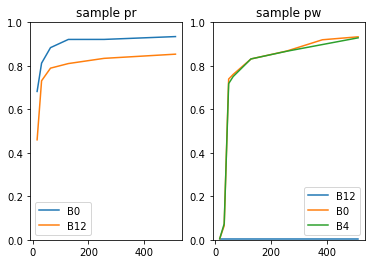

In [7]:
for cmd, typ_data in f1.items():
    #print(cmd)
    for typ, blur_data in typ_data.items():
        if typ == "pr":
            spid = 1
        else:
            spid = 2
        #print(typ)
        for blur, data in blur_data.items():
            #print(blur)
            n_feat_sorted = list(data.keys())
            n_feat_sorted.sort()
            f1_sorted = [data[k] for k in n_feat_sorted]
            #rint(f1_sorted)
            plt.subplot(1, 2, spid)
            plt.title("%s %s" % (cmd, typ))
            ax = plt.gca()
            ax.set_ylim([0.0, 1.0])
            ax.plot(n_feat_sorted, f1_sorted, label='B%d' % blur)
            ax.legend()
            with open("./sample_f1/sample_f1_%s_b_%d.csv" % (typ, blur), "w") as fd:
                fd.write("nfeat,f1macroavg,\n")
                fd.write("0,0,\n")
                for nf, f1 in zip(n_feat_sorted, f1_sorted):
                    fd.write("%d,%f,\n"  % (nf, f1))
    plt.show()

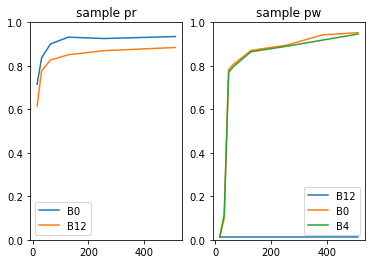

In [8]:
for cmd, typ_data in recall.items():
    #print(cmd)
    for typ, blur_data in typ_data.items():
        if typ == "pr":
            spid = 1
        else:
            spid = 2
        #print(typ)
        for blur, data in blur_data.items():
            #print(blur)
            n_feat_sorted = list(data.keys())
            n_feat_sorted.sort()
            f1_sorted = [data[k] for k in n_feat_sorted]
            #rint(f1_sorted)
            plt.subplot(1, 2, spid)
            plt.title("%s %s" % (cmd, typ))
            ax = plt.gca()
            ax.set_ylim([0.0, 1.0])
            ax.plot(n_feat_sorted, f1_sorted, label='B%d' % blur)
            ax.legend()
            with open("./sample_f1/sample_recall_%s_b_%d.csv" % (typ, blur), "w") as fd:
                fd.write("nfeat,f1macroavg,\n")
                fd.write("0,0,\n")
                for nf, f1 in zip(n_feat_sorted, f1_sorted):
                    fd.write("%d,%f,\n"  % (nf, f1))
    plt.show()

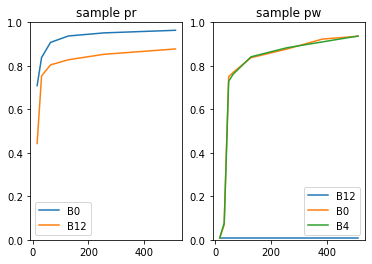

In [9]:
for cmd, typ_data in prec.items():
    #print(cmd)
    for typ, blur_data in typ_data.items():
        if typ == "pr":
            spid = 1
        else:
            spid = 2
        #print(typ)
        for blur, data in blur_data.items():
            #print(blur)
            n_feat_sorted = list(data.keys())
            n_feat_sorted.sort()
            f1_sorted = [data[k] for k in n_feat_sorted]
            #rint(f1_sorted)
            plt.subplot(1, 2, spid)
            plt.title("%s %s" % (cmd, typ))
            ax = plt.gca()
            ax.set_ylim([0.0, 1.0])
            ax.plot(n_feat_sorted, f1_sorted, label='B%d' % blur)
            ax.legend()
            with open("./sample_f1/sample_prec_%s_b_%d.csv" % (typ, blur), "w") as fd:
                fd.write("nfeat,precmacroavg,\n")
                fd.write("0,0,\n")
                for nf, f1 in zip(n_feat_sorted, f1_sorted):
                    fd.write("%d,%f,\n"  % (nf, f1))
    plt.show()